In [1]:
import pandas as pd
import numpy as np
from src.scripts import timeseries_anim
import json

In [2]:
df = pd.read_csv(
    "../data/BindingDB_All.tsv",
    sep="\t",
    usecols=[
        "Ligand SMILES",
        "UniProt (SwissProt) Primary ID of Target Chain",
        "DrugBank ID of Ligand",
        "IC50 (nM)",
        "Article DOI",
        "Institution",
        "Patent Number",
        "ZINC ID of Ligand",
    ],
)

C:\Users\grede\AppData\Local\Temp\ipykernel_3488\2446788585.py:1: DtypeWarning: Columns (9,17,21,23,33,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


In [3]:
# load initial data
uniprot_ids = ["P03367", "P37238"]  # TODO: find RET and other interestig ones
targets = timeseries_anim.filter_RET(df, uniprot_ids=uniprot_ids)

In [4]:
# citations
with open("../src/data/citations.json", "r") as f:
    citations = json.load(f)
citations = pd.DataFrame(citations)

# merge
targets = (
    pd.merge(
        left=targets,
        right=citations,
        left_on="Article DOI",
        right_on="doi",
        how="outer",
    )
    .dropna(subset="Ligand SMILES")
    .drop(columns="Article DOI")
)

In [5]:
# patents
with open("../src/data/patents.json", "r") as f:
    patents = json.load(f)
patents_df = pd.DataFrame(
    [
        {
            "patent": patent["patent"],
            "patent_status": patent["info"].get("status", np.nan),
            "families citing": int(patent["info"].get("families citing", 0) or 0),
            "cited by": int(patent["info"].get("cited by", 0) or 0),
        }
        for patent in patents
        if isinstance(patent, dict) and isinstance(patent.get("info"), dict)
    ]
)
patents_df["patent_citations"] = patents_df["families citing"] + patents_df["cited by"]
patents_df.drop(columns=["families citing", "cited by"], inplace=True)

# merge
targets = (
    pd.merge(
        left=targets,
        right=patents_df,
        left_on="Patent Number",
        right_on="patent",
        how="outer",
    )
    .dropna(subset="Ligand SMILES")
    .drop(columns="Patent Number")
)

In [6]:
# TODO: clinical trials: check clinical_trials.ipynb and understand how to get the graphs
# count data into the current df (by merging on ZINC IDs, which are already in 'targets')

In [7]:
# clean IC50
targets.replace(" NV,", np.nan, inplace=True)
targets["IC50 (nM)"] = targets["IC50 (nM)"].astype(str).str.replace(" C", "")
targets["IC50 (nM)"] = (
    targets["IC50 (nM)"]
    .astype(str)
    .str.replace(">", "")
    .str.replace("<", "")
    .astype(float)
)
targets["log_ic50"] = targets["IC50 (nM)"].apply(np.log10)
targets.drop(columns="IC50 (nM)", inplace=True)

In [8]:
# mark nan as -1 for plots
# TODO: everything negative in plots is actually Nan, would be nice to have this less hacky
targets[targets.isna()] = -1

In [13]:
# fingerprints
targets = timeseries_anim.get_ligands_fingerprint(targets)

# pca applied to each target seperately
store = []
for target in targets["UniProt (SwissProt) Primary ID of Target Chain"].unique():
    temp = targets[
        targets["UniProt (SwissProt) Primary ID of Target Chain"] == target
    ].copy()
    temp, _, _ = timeseries_anim.PCA_fingerprints(temp)
    store.append(temp)
result = pd.concat(store, ignore_index=True)

## final data has info for pca overlayed with:
# - ic50
# - citations (article)
# - patent citations
result.sample(5)

,Ligand SMILES,Institution,DrugBank ID of Ligand,ZINC ID of Ligand,UniProt (SwissProt) Primary ID of Target Chain,doi,citation,patent,patent_status,patent_citations,log_ic50,Ligand Fingerprint,PC1,PC2,PC3
349,COc1ccc(cc1)S(=O)(=O)N(C[C@@H](O)CN1[C@@H](Cc2...,GlaxoSmithKline,-1,ZINC14953627,P03367,10.1016/j.bmcl.2006.07.014,20.0,-1,-1,-1.0,-1.000000,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.990004,1.373993,-0.520862
532,O[C@@H](C[C@@H](Cc1ccccc1)C(=O)NC1[C@H](O)Cc2c...,University of Pennsylvania,-1,ZINC14943126,P03367,10.1021/jm0204587,55.0,-1,-1,-1.0,-1.522879,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.350717,-4.720332,4.612234
629,COc1ccc2c(OCCCCCCCC(C)(C)CN(C[C@@H](O)[C@H](Cc...,Purdue University,-1,ZINC49694396,P03367,10.1021/jm900695w,37.0,-1,-1,-1.0,-1.000000,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",14.735868,15.754577,-3.252236
2,C[C@@H]1C[C@@H]2[C@H]([C@@H]3C=C(CN4C(=O)c5ccc...,GlaxoSmithKline Intellectual Property Developm...,-1,-1,P03367,10.1021/acsinfecdis.0c00168,236.0,US10583140,Active,2.0,-1.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",-4.286524,-3.514112,-4.497976
670,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(C\C=C\c2cc...,DuPont Pharmaceuticals Company,-1,ZINC14907416,P03367,10.1021/jm9602571,150.0,-1,-1,-1.0,-1.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-2.075135,-3.789217,-4.696504


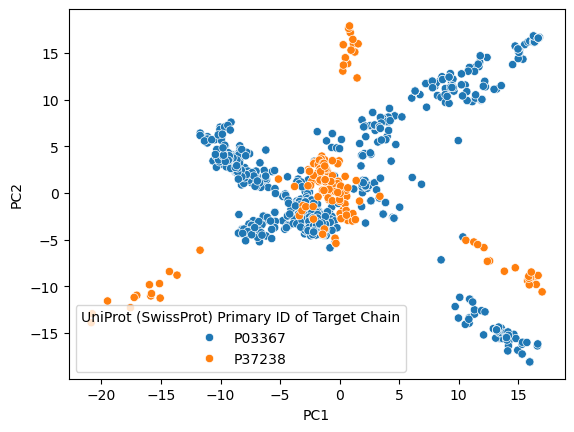

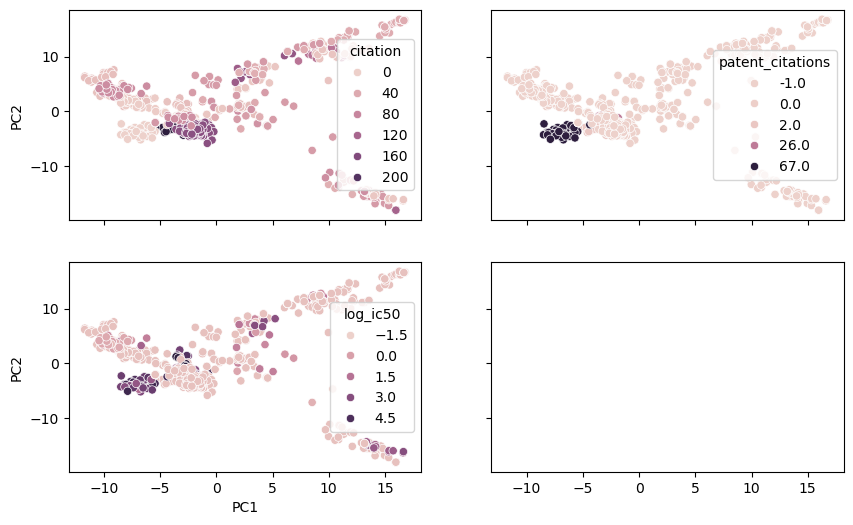

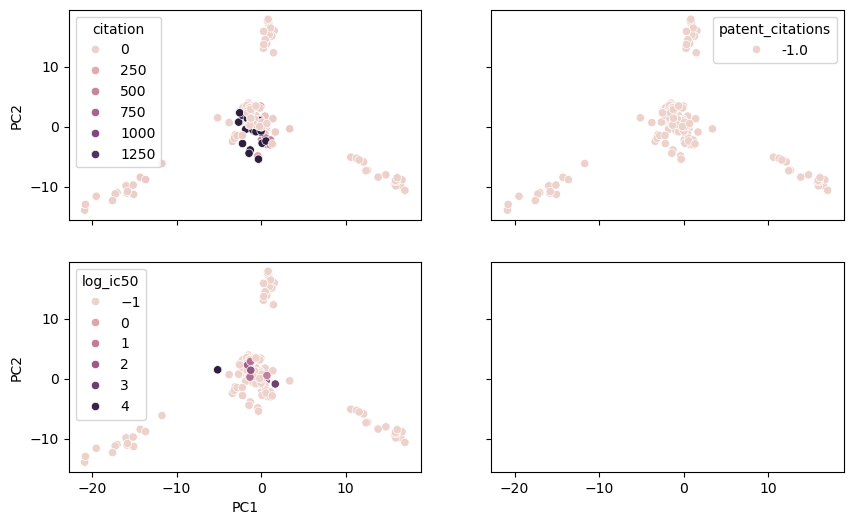

In [10]:
# examples:
import seaborn as sns
from matplotlib import pyplot as plt

# pcas of each target
sns.scatterplot(
    result, x="PC1", y="PC2", hue="UniProt (SwissProt) Primary ID of Target Chain"
)
plt.show()

# seperating each pca and overlaying stuff
# TODO: plotly
for target in targets["UniProt (SwissProt) Primary ID of Target Chain"].unique():
    fig, axs = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(10, 6))
    sns.scatterplot(
        result[result["UniProt (SwissProt) Primary ID of Target Chain"] == target],
        x="PC1",
        y="PC2",
        hue="citation",
        ax=axs[0, 0],
    )
    sns.scatterplot(
        result[result["UniProt (SwissProt) Primary ID of Target Chain"] == target],
        x="PC1",
        y="PC2",
        hue="patent_citations",
        ax=axs[0, 1],
    )
    sns.scatterplot(
        result[result["UniProt (SwissProt) Primary ID of Target Chain"] == target],
        x="PC1",
        y="PC2",
        hue="log_ic50",
        ax=axs[1, 0],
    )
    plt.show()

<Axes: xlabel='PC1', ylabel='PC2'>

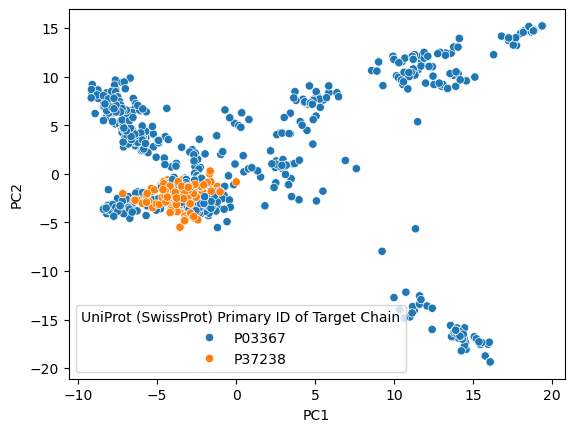

In [ ]:
# TODO: read, ackownledge, understand, agree and delete

# for wes just to show why i seperate targets before applying pca,
# this is done without target seperation prior to pca
# (different targets at not comparable chemically)
result2, _, _ = timeseries_anim.PCA_fingerprints(targets)
sns.scatterplot(
    result2, x="PC1", y="PC2", hue="UniProt (SwissProt) Primary ID of Target Chain"
)